# Balık Sınıflandırma Projesi
Bu proje, Akbank Derin Öğrenme Bootcamp kapsamında gerçekleştirilen bir sınıflandırma projesidir. Amacımız, Kaggle üzerinde yer alan büyük ölçekli balık veri seti ile bir derin öğrenme modeli geliştirerek farklı balık türlerini sınıflandırmaktır.


# Gerekli Kütüphanlerin Import Edilmesi

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



import warnings
warnings.filterwarnings("ignore")

# Veri Önişleme Aşaması
Bu aşamada, Kaggle üzerinde bulunan veri seti ile çalışacağız. Veri seti, farklı balık türlerini içeren resim dosyalarından oluşmaktadır. Resimleri bir DataFrame yapısına dönüştüreceğiz ve veriyi eğitim/test olarak ayıracağız

In [10]:

# Veri setinin bulunduğu temel dizin
base_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Balık türlerinin bulunduğu klasörler (etiketler)
classes = [i for i in os.listdir(base_dir) if '.' not in i]                    
classes
# Görüntü yolları ve etiketleri tutacak listeler
label = []
path = []

# Her bir balık türü klasörünü ve içindeki dosyaları geziyoruz
for fish_type in classes:
    fish_dir = os.path.join(base_dir, fish_type)
    for dir_name, _, filenames in os.walk(fish_dir):
        for filename in filenames:
            # Dosya adı .png ile bitiyorsa ve klasör adı 'GT' içermiyorsa
            if filename.endswith('.png') and 'GT' not in dir_name:
                label.append(fish_type)  # Balık türünü etiket olarak ekliyoruz
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu ekliyoruz

# Yolları ve etiketleri içeren bir DataFrame oluşturma
data = pd.DataFrame({'path': path, 'label': label})

# DataFrame'i görüntüleme
print(data)




                                                   path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]


# Veri Setini İnceleme 

In [11]:
# Veri seti boyutları ve sütun bilgileri
print(f"DataFrame boyutu: {data.shape}")
print(data.info())

# Etiketlerin sınıf dağılımını inceleme
class_distribution = data['label'].value_counts()
print(class_distribution)

DataFrame boyutu: (9000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


# Veri Setini Görselleştirme

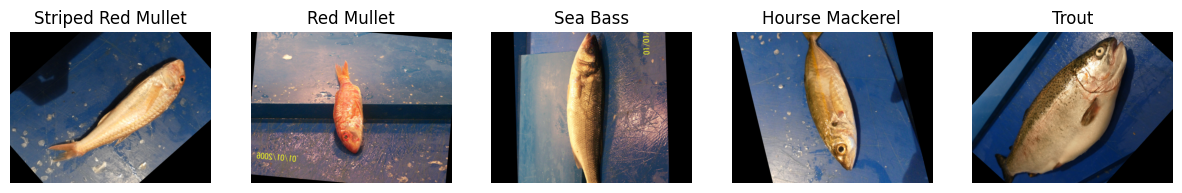

In [12]:

# Veri setinden rastgele 5 görüntü ve etiketlerini görselleştirelim
sample_data = data.sample(5).reset_index()

plt.figure(figsize=(15, 10))
for i in range(5):
    img = Image.open(sample_data.loc[i, 'path'])
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(sample_data.loc[i, 'label'])
    plt.axis('off')




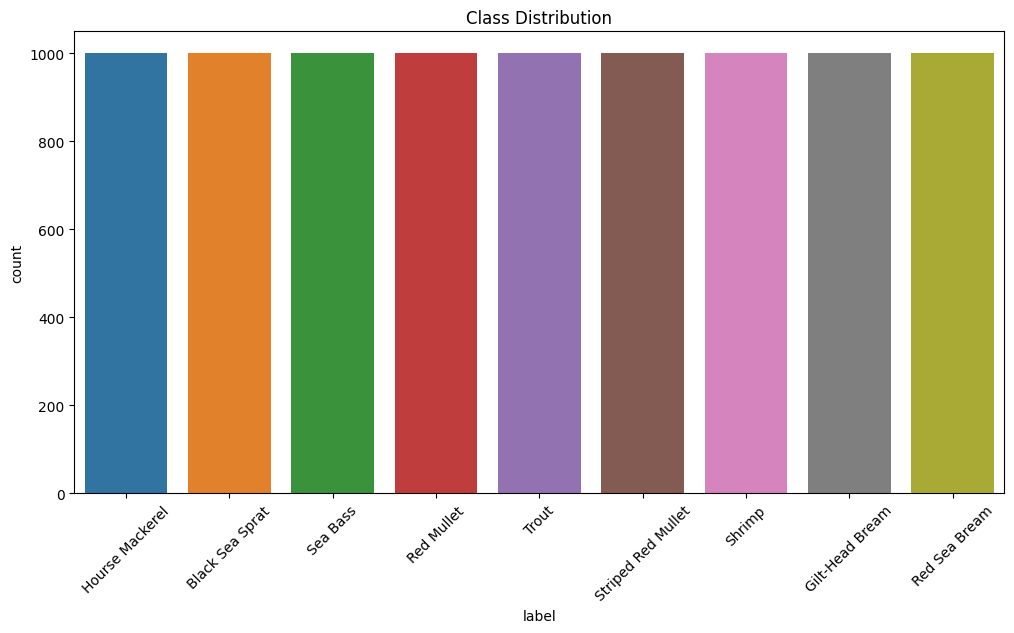

In [13]:
#Grafik gösterimi 
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=data) # x: Classes
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.show()

# Train-Test Ayrımı

In [15]:
# Görüntü boyutunu belirleyelim (224x224)
img_size = (224, 224)

# Görüntüleri ve etiketleri depolayacak listeler
images = []
labels = []

# Veri setindeki her bir görüntüyü numarik formata dönüştürme
for idx, row in data.iterrows():
    img = load_img(row['path'], target_size=img_size)
    img_array = img_to_array(img) / 255.0  # 0-255 arasındaki değerleri 0-1 arasına ölçeklendir
    images.append(img_array)
    labels.append(row['label'])

# Görüntü ve etiket listelerini NumPy dizisine dönüştürme
X = np.array(images)
y = np.array(labels)

# Eğitim ve test seti olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Ayrılan veri setlerinin boyutlarını kontrol edelim
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (7200, 224, 224, 3)
X_test shape: (1800, 224, 224, 3)
y_train shape: (7200,)
y_test shape: (1800,)


# Modelin Oluşturulması



In [16]:
# Etiketleri one-hot encode edelim
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

# Modelin giriş şekli ve sınıf sayısını belirleyelim
input_shape = X_train.shape[1:]  # (224, 224, 3)
num_classes = y_train_encoded.shape[1]  # Sınıf sayısı

# Modelin tanımlanması
model = Sequential([
    Input(shape=input_shape),
    Flatten(),  # Görüntüyü tek boyutlu bir vektöre dönüştür
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])






# Modelin Derlenmesi


In [17]:
# Modelin derlenmesi
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini görüntüleme
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,839,561 (590.67 MB)

 Trainable params: 154,835,721 (590.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

# Modelin Eğitilmesi 

In [18]:
# Callback'lerin tanımlanması
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Modelin eğitilmesi
history = model.fit(
    X_train, y_train_encoded,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.2001 - loss: 2.8553 - val_accuracy: 0.1826 - val_loss: 4.3438 - learning_rate: 0.0010
Epoch 2/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.2912 - loss: 2.1291 - val_accuracy: 0.4451 - val_loss: 1.5170 - learning_rate: 0.0010
Epoch 3/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.3590 - loss: 1.7804 - val_accuracy: 0.5799 - val_loss: 1.2257 - learning_rate: 0.0010
Epoch 4/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.4577 - loss: 1.5031 - val_accuracy: 0.6465 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 5/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.5226 - loss: 1.3170 - val_accuracy: 0.6618 - val_loss: 0.9357 - learning_rate: 0.0010
Epoch 6/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.5768 - loss: 1.1601 - val_accuracy: 0.6972 - val_loss: 0.8647 - learning_rate: 0.0010
Epoch 7/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6434 - loss: 1.

# Modelin Değerlendirilmesi

Test Loss: 0.1154
Test Accuracy: 0.9650
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step


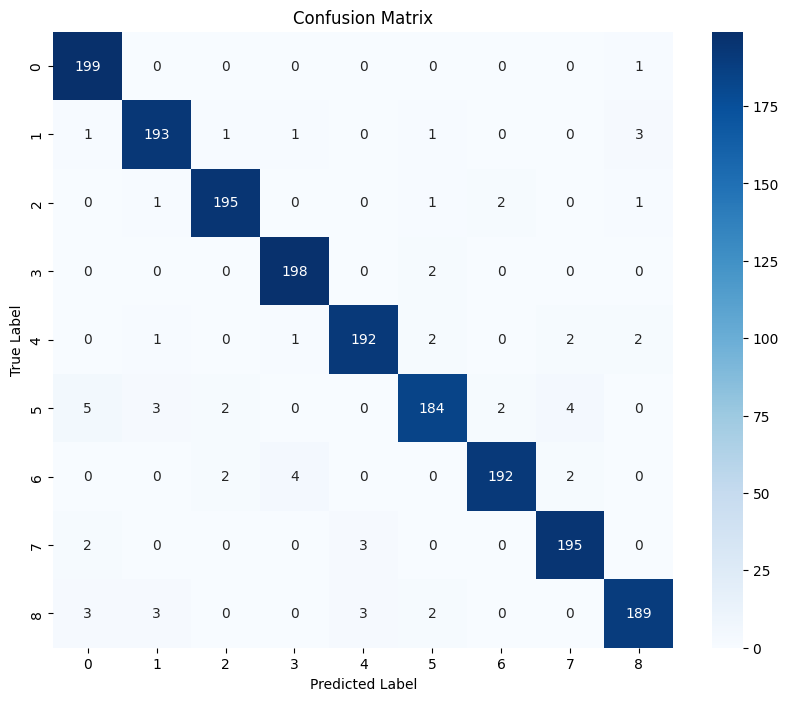

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       200
           1       0.96      0.96      0.96       200
           2       0.97      0.97      0.97       200
           3       0.97      0.99      0.98       200
           4       0.97      0.96      0.96       200
           5       0.96      0.92      0.94       200
           6       0.98      0.96      0.97       200
           7       0.96      0.97      0.97       200
           8       0.96      0.94      0.95       200

    accuracy                           0.96      1800
   macro avg       0.97      0.97      0.96      1800
weighted avg       0.97      0.96      0.96      1800



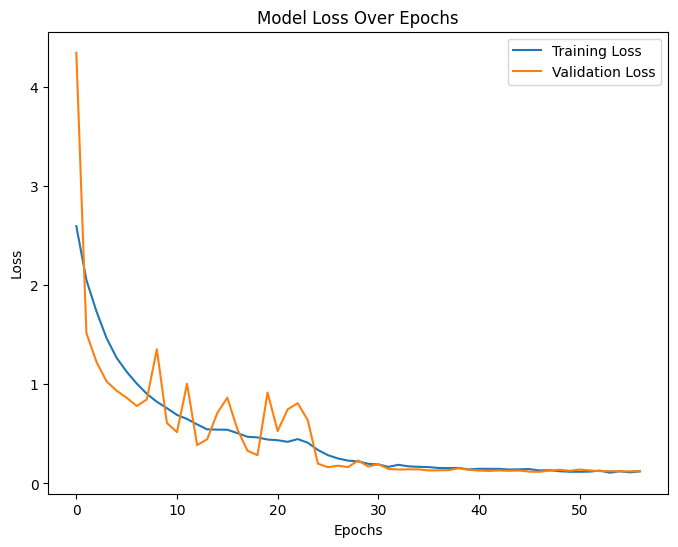

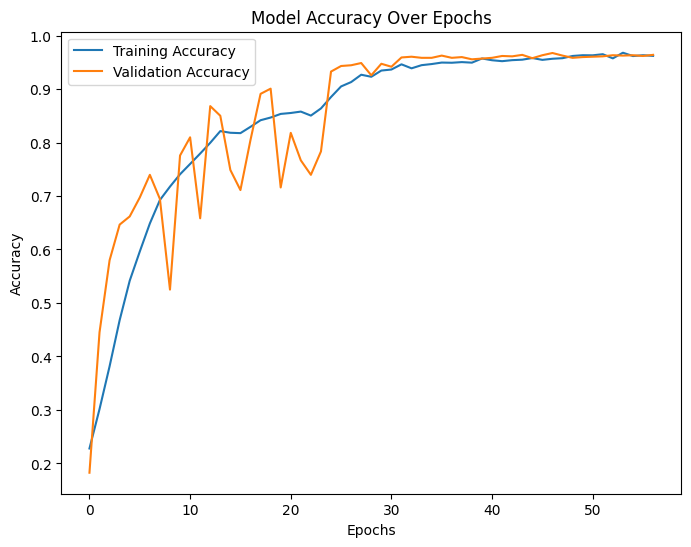

In [19]:
# Modeli test seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Tahminlerde bulunma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_test_encoded, axis=1)  # Gerçek sınıflar

# Confusion Matrix oluşturma
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report oluşturma
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)

# Eğitim sürecinin kayıp fonksiyonunu görselleştirme
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Kayıp fonksiyonunu çizdirme
plot_loss(history)

# Eğitim sürecinin doğruluğunu görselleştirme
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Doğruluğu çizdirme
plot_accuracy(history)
